In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
from sklearn.metrics import jaccard_score
from sklearn.metrics import normalized_mutual_info_score
from scipy.stats import spearmanr

In [3]:
# Load Data 
ranked_data = pd.read_csv("../data/data_y_real.csv")
ranked_data['o_s'] = ranked_data['d_c'] + ranked_data['d_i']
outbreak_sizes = ranked_data.groupby(["seed"])["o_s"].agg("max")
new_df = pd.DataFrame()
new_df["seed"] = outbreak_sizes.index
# Get Full Outbreak Size
new_df["real_os"] = list(outbreak_sizes)
ranked_data = ranked_data.merge(new_df,left_on="seed",right_on="seed")
ranked_data = ranked_data[ranked_data["o_s"] > 0]
out_sizes = [ x for x in list(outbreak_sizes)  if x > 0 ]
# Count Number of times 
just_zero = ranked_data[ranked_data['o_s'] == 0].groupby(['seed']).size().rename('n_outbreaks')
zero_ids = list(just_zero.index)
seed_amount = len(set(ranked_data["seed"]))
## if an outbreak occurs - what is probability of detecting it for a given sentinel? 
g_zero = (ranked_data.groupby(["seed"])["real_os"].agg("max"))
ranked_data["norm_dt"] = ranked_data["d_t"] / 512
ranked_data["norm_di"] = ranked_data["d_i"] / ranked_data["real_os"]
ranked_data["norm_df"] = ((ranked_data["d_f"]) / seed_amount)
#sum_rank_df = ranked_data.groupby(["sent"])["d_f"].agg("sum")/1503
#sum_rank_df = 1 - sum_rank_df

## Now, lets get the ranking list of the top 1%, 5%, and 10 % of nodes
## Then, find the jaccard similarity comparing the lists
## Let's also find the NMI

In [4]:
# ----------------------------------------------------
# Aggregate per sentinel
# ----------------------------------------------------
agg = ranked_data.groupby("sent", as_index=True).agg(
    dF_sum=("norm_df", "sum"),     # total detections (higher better)
    dI_mean=("norm_di", "mean"),   # mean infections at detection (lower better)
    dT_mean=("norm_dt", "mean"),   # mean time to detection (lower better)
)
agg["dF_sum"] = 1- agg["dF_sum"]
# ----------------------------------------------------
# Compute ranks (1 = best)
# ----------------------------------------------------
agg["R_F"] = agg["dF_sum"].rank(ascending=True, method="min")
agg["R_I"] = agg["dI_mean"].rank(ascending=True,  method="min")
agg["R_T"] = agg["dT_mean"].rank(ascending=True,  method="min")

ranks = agg[["R_F", "R_I", "R_T"]]
n = len(ranks)

# ----------------------------------------------------
# Top-k thresholds
# ----------------------------------------------------
pct = {"top1": 0.01, "top5": 0.05, "top10": 0.10}
ks = {name: max(1, int(np.ceil(p * n))) for name, p in pct.items()}

def top_k_set(r: pd.Series, k: int) -> set:
    """Return indices with rank <= kth smallest rank (ties included)."""
    k = max(1, min(k, len(r)))
    kth = np.sort(np.asarray(r, dtype=float))[k - 1]
    return set(r.index[r <= kth])

top_sets = {
    m: {thr: top_k_set(ranks[m], k) for thr, k in ks.items()}
    for m in ["R_F", "R_I", "R_T"]
}

# ----------------------------------------------------
# Similarity metrics (Jaccard, NMI, Spearman)
# ----------------------------------------------------
def jaccard(a: set, b: set) -> float:
    return 1.0 if not a and not b else len(a & b) / max(1, len(a | b))

universe = ranks.index.sort_values()
def membership_series(members: set) -> pd.Series:
    s = pd.Series(0, index=universe, dtype=int)
    if members:
        s.loc[list(members)] = 1
    return s

pairs = [("R_F", "R_I"), ("R_F", "R_T"), ("R_I", "R_T")]
jaccard_results, nmi_results, corr_results = {}, {}, {}

for thr in pct.keys():
    jaccard_results[thr], nmi_results[thr], corr_results[thr] = {}, {}, {}
    for a, b in pairs:
        A, B = top_sets[a][thr], top_sets[b][thr]
        # Jaccard
        jaccard_results[thr][f"{a}_vs_{b}"] = jaccard(A, B)
        # NMI (binary membership)
        la, lb = membership_series(A), membership_series(B)
        nmi_results[thr][f"{a}_vs_{b}"] = normalized_mutual_info_score(la, lb)
        # Spearman correlation on full ranks (not just top-k)
        rho, _ = spearmanr(ranks[a], ranks[b])
        corr_results[thr][f"{a}_vs_{b}"] = float(rho)

# ----------------------------------------------------
# Output summary
# ----------------------------------------------------
print(f"Total sentinels: {n}")
print("k sizes:", ks)
for thr in pct.keys():
    print(f"\n=== Threshold: {thr} ===")
    print("Jaccard:")
    for k, v in jaccard_results[thr].items():
        print(f"  {k}: {v:.4f}")
    print("NMI (sklearn):")
    for k, v in nmi_results[thr].items():
        print(f"  {k}: {v:.4f}")
    print("Spearman ρ (full ranks):")
    for k, v in corr_results[thr].items():
        print(f"  {k}: {v:.4f}")

# Optional: keep useful objects
# agg, ranks, top_sets, jaccard_results, nmi_results, corr_results

Total sentinels: 1503
k sizes: {'top1': 16, 'top5': 76, 'top10': 151}

=== Threshold: top1 ===
Jaccard:
  R_F_vs_R_I: 0.1786
  R_F_vs_R_T: 0.0000
  R_I_vs_R_T: 0.1429
NMI (sklearn):
  R_F_vs_R_I: 0.1472
  R_F_vs_R_T: 0.0020
  R_I_vs_R_T: 0.1108
Spearman ρ (full ranks):
  R_F_vs_R_I: 0.8443
  R_F_vs_R_T: 0.8379
  R_I_vs_R_T: 0.9317

=== Threshold: top5 ===
Jaccard:
  R_F_vs_R_I: 0.5357
  R_F_vs_R_T: 0.4215
  R_I_vs_R_T: 0.6170
NMI (sklearn):
  R_F_vs_R_I: 0.4555
  R_F_vs_R_T: 0.3313
  R_I_vs_R_T: 0.5407
Spearman ρ (full ranks):
  R_F_vs_R_I: 0.8443
  R_F_vs_R_T: 0.8379
  R_I_vs_R_T: 0.9317

=== Threshold: top10 ===
Jaccard:
  R_F_vs_R_I: 0.6218
  R_F_vs_R_T: 0.6218
  R_I_vs_R_T: 0.7062
NMI (sklearn):
  R_F_vs_R_I: 0.4980
  R_F_vs_R_T: 0.4980
  R_I_vs_R_T: 0.5964
Spearman ρ (full ranks):
  R_F_vs_R_I: 0.8443
  R_F_vs_R_T: 0.8379
  R_I_vs_R_T: 0.9317


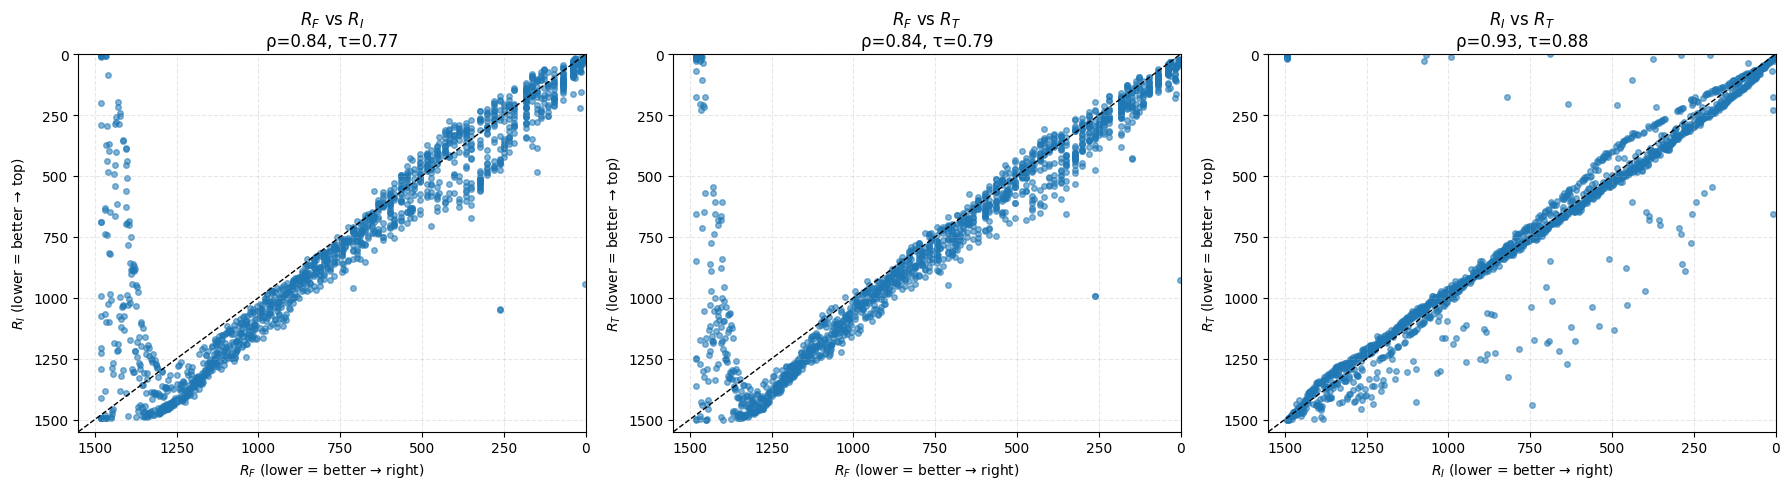

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, kendalltau

r_f = np.asarray(agg["R_F"], dtype=float)
r_t = np.asarray(agg["R_T"], dtype=float)

def scatter_rank_true(x, y, xlab, ylab, fname, jitter=0.0):
    """Scatter for true ranks: left/bottom = worse (high rank), right/top = better (low rank)."""
    mask = np.isfinite(x) & np.isfinite(y)
    x, y = x[mask], y[mask]

    if jitter > 0:
        rng = np.random.default_rng(42)
        x = x + rng.normal(0, jitter, size=len(x))
        y = y + rng.normal(0, jitter, size=len(y))

    rho, _ = spearmanr(x, y)
    tau, _ = kendalltau(x, y)

    fig, ax = plt.subplots(figsize=(6.5, 5.5))
    ax.scatter(x, y, s=16, alpha=0.55)

    # 1:1 reference line
    r_min, r_max = float(x.min()), float(x.max())
    ax.plot([r_max, r_min], [r_max, r_min], "--", color="k", lw=1)

    # orientation: higher (worse) → left/bottom, lower (better) → right/top
    ax.set_xlim(r_max, r_min)
    ax.set_ylim(r_max, r_min)

    ax.set_xlabel(f"{xlab} (lower = better → right)")
    ax.set_ylabel(f"{ylab} (lower = better → top)")
    ax.set_title(f"{xlab} vs {ylab}\nSpearman ρ={rho:.2f}, Kendall τ={tau:.2f}")
    ax.grid(True, linestyle="--", alpha=0.3)

    # nice tick spacing for ~1500 values
    step = 250
    ticks = np.arange(1500, 0, -step)
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)

    fig.tight_layout()
    fig.savefig(fname, dpi=300, bbox_inches="tight")
    plt.show()

# Run for R_F vs R_T
#scatter_rank_true(r_f, r_t, r"$R_F$", r"$R_T$", "rank_RF_vs_RT_true.png", jitter=0.15)
#scatter_rank_true(r_f, r_i, r"$R_F$", r"$R_I$", "rank_RF_vs_RI_true.png", jitter=0.15)
#scatter_rank_true(r_i, r_t, r"$R_I$", r"$R_T$", "rank_RI_vs_RT_true.png", jitter=0.15)
r_f = np.asarray(agg["R_F"], dtype=float)
r_i = np.asarray(agg["R_I"], dtype=float)
r_t = np.asarray(agg["R_T"], dtype=float)

pairs = [
    (r_f, r_i, r"$R_F$", r"$R_I$"),
    (r_f, r_t, r"$R_F$", r"$R_T$"),
    (r_i, r_t, r"$R_I$", r"$R_T$")
]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, (x, y, xlab, ylab) in zip(axes, pairs):
    mask = np.isfinite(x) & np.isfinite(y)
    x, y = x[mask], y[mask]
    rho, _ = spearmanr(x, y)
    tau, _ = kendalltau(x, y)

    ax.scatter(x, y, s=16, alpha=0.55)
    
    # consistent limits and inverted orientation
    r_min, r_max = 0, 1550
    ax.plot([r_max, r_min], [r_max, r_min], "--", color="k", lw=1)
    ax.set_xlim(r_max, r_min)
    ax.set_ylim(r_max, r_min)

    # axis labels and title
    ax.set_xlabel(f"{xlab} (lower = better → right)")
    ax.set_ylabel(f"{ylab} (lower = better → top)")
    ax.set_title(f"{xlab} vs {ylab}\nρ={rho:.2f}, τ={tau:.2f}")
    ax.grid(True, linestyle="--", alpha=0.3)

    # tick marks every 250 ranks
    ticks = np.arange(1500, -1, -250)
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)

plt.tight_layout()
plt.savefig("rank_pairwise_row.png", dpi=300, bbox_inches="tight")
plt.show()

In [6]:
# correlation diagnostics
print("Spearman correlations on full ranks:")
print(ranks.corr(method="spearman"))

print("\nTop 10 sentinels by each metric:")
for col in ["R_F", "R_I", "R_T"]:
    print(f"\nTop 10 by {col}:")
    print(ranks[col].sort_values().head(10))

Spearman correlations on full ranks:
          R_F       R_I       R_T
R_F  1.000000  0.844282  0.837851
R_I  0.844282  1.000000  0.931671
R_T  0.837851  0.931671  1.000000

Top 10 sentinels by each metric:

Top 10 by R_F:
sent
8515     1.0
29744    2.0
9775     2.0
21695    4.0
30148    4.0
30069    4.0
29969    4.0
30073    4.0
30385    4.0
30361    4.0
Name: R_F, dtype: float64

Top 10 by R_I:
sent
9720      1.0
30486     2.0
9767      3.0
21680     4.0
9940      5.0
9200      6.0
8167      7.0
8136      8.0
8133      9.0
30925    10.0
Name: R_I, dtype: float64

Top 10 by R_T:
sent
21125     1.0
22672     2.0
24499     3.0
8096      4.0
24584     5.0
23092     6.0
9767      7.0
10448     8.0
2670      8.0
9940     10.0
Name: R_T, dtype: float64


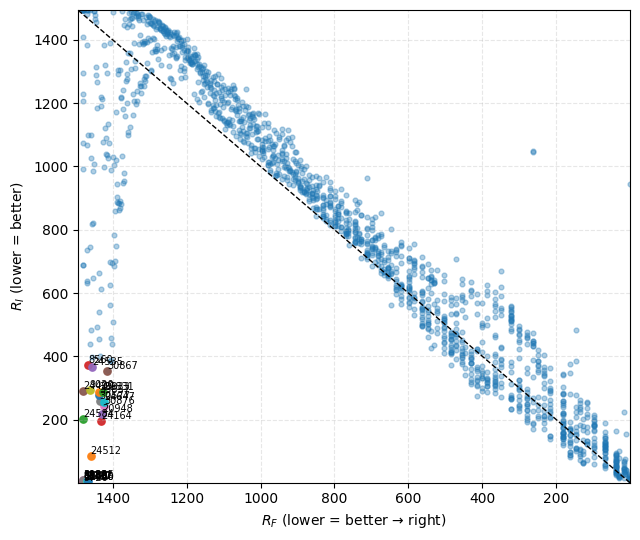

,sent,R_F,R_I,gap_FI,R_F_norm,R_I_norm,rgap_FI
0,9720,1480.0,1.0,1479.0,1.0,0.000000,1.000000
1,30486,1480.0,2.0,1478.0,1.0,0.000670,0.999330
2,21680,1480.0,4.0,1476.0,1.0,0.002009,0.997991
3,9940,1480.0,5.0,1475.0,1.0,0.002679,0.997321
4,8136,1480.0,8.0,1472.0,1.0,0.004689,0.995311


In [7]:
df = agg.copy()

# normalize ranks
for c in ["R_F","R_I","R_T"]:
    df[c+"_norm"] = (df[c]-df[c].min())/(df[c].max()-df[c].min())

# discordance
df["gap_FI"]  = (df["R_F"] - df["R_I"]).abs()
df["rgap_FI"] = (df["R_F_norm"] - df["R_I_norm"]).abs()

# top-K outliers (use index as the node id)
K = 25
out = df.sort_values("rgap_FI", ascending=False).head(K)

# plot + labels from index
import numpy as np, matplotlib.pyplot as plt
plt.figure(figsize=(6.5,5.5))
plt.scatter(df["R_F"], df["R_I"], s=12, alpha=.35)
mn = float(np.minimum(df["R_F"].min(), df["R_I"].min()))
mx = float(np.maximum(df["R_F"].max(), df["R_I"].max()))
plt.plot([mn,mx],[mn,mx],'--',lw=1,color='k')
plt.xlim(mn,mx); plt.ylim(mn,mx); plt.gca().invert_xaxis()
plt.xlabel(r"$R_F$ (lower = better → right)")
plt.ylabel(r"$R_I$ (lower = better)")
plt.grid(True, ls="--", alpha=.3)

for idx, r in out.iterrows():
    plt.scatter(r["R_F"], r["R_I"], s=28, alpha=.9)
    plt.text(r["R_F"], r["R_I"], str(idx), fontsize=7, ha='left', va='bottom')

plt.tight_layout(); plt.savefig("RF_vs_RI_outliers.png", dpi=300, bbox_inches="tight"); plt.show()

# table with index preserved
out_table = out.loc[:, ["R_F","R_I","gap_FI","R_F_norm","R_I_norm","rgap_FI"]]
out_table.index.name = "sent"
out_table = out_table.reset_index()
out_table.head()


In [8]:
# === Combine raw aggregates + ranks ===
rank_table = (
    agg[["dF_sum", "dI_mean", "dT_mean"]]
    .join(ranks[["R_F", "R_I", "R_T"]])
    .sort_values(["R_F", "R_I", "R_T"], ascending=[True, True, True])
)

### load centrality data now
cent_data = pd.read_csv("../nz_hort_cent.csv")
cent_data = cent_data.rename(columns={"node_id":"sent"})
cent_data = cent_data.set_index("sent")

### join rank_table and cent_table
rank_table = rank_table.join(cent_data)
rank_table = rank_table.drop(columns={"Unnamed: 0"})

# Peek
print("\nRank table (raw values + ranks):")
print(rank_table.head(20))

# Save to CSV (one file with everything)
rank_table.to_csv("sentinel_rank_table.csv", index=True)
print("\nSaved: sentinel_rank_table.csv")

# === If you want per-metric sorted views (top→bottom) ===
by_RF = rank_table.sort_values("R_F", ascending=True)
by_RI = rank_table.sort_values("R_I", ascending=True)
by_RT = rank_table.sort_values("R_T", ascending=True)

by_RF.head(20).to_csv("top_by_RF.csv")
by_RI.head(20).to_csv("top_by_RI.csv")
by_RT.head(20).to_csv("top_by_RT.csv")
print("Saved: top_by_RF.csv, top_by_RI.csv, top_by_RT.csv")

# === (Optional) add membership flags for top1/5/10 per metric ===
def add_membership_flags(df, ranks, ks, prefix):
    out = df.copy()
    for thr, k in ks.items():
        kth = np.sort(np.asarray(ranks, dtype=float))[k-1]
        mask = (ranks <= kth).astype(int)
        out[f"{prefix}_{thr}"] = mask
    return out

rank_table_flags = rank_table.copy()
rank_table_flags = add_membership_flags(rank_table_flags, ranks["R_F"], ks, "in_RF")
rank_table_flags = add_membership_flags(rank_table_flags, ranks["R_I"], ks, "in_RI")
rank_table_flags = add_membership_flags(rank_table_flags, ranks["R_T"], ks, "in_RT")

rank_table_flags.to_csv("sentinel_rank_table_with_flags.csv")
print("Saved: sentinel_rank_table_with_flags.csv")

# === (Optional) print top-k with raw values per threshold & metric ===
for thr, k in ks.items():
    print(f"\n--- Top {thr} by R_F (k={k}) ---")
    print(by_RF.head(k)[["dF_sum", "R_F"]])
    print(f"\n--- Top {thr} by R_I (k={k}) ---")
    print(by_RI.head(k)[["dI_mean", "R_I"]])
    print(f"\n--- Top {thr} by R_T (k={k}) ---")
    print(by_RT.head(k)[["dT_mean", "R_T"]])



Rank table (raw values + ranks):
         dF_sum   dI_mean   dT_mean   R_F    R_I    R_T  i_d  o_d     o_w  \
sent                                                                        
8515   0.077694  0.633082  0.702991   1.0  944.0  927.0    3    3     4.0   
9775   0.091479  0.044794  0.395892   2.0   11.0   22.0   72   81  1108.0   
29744  0.091479  0.048637  0.402833   2.0   12.0   23.0   58   56   749.0   
30148  0.092105  0.049419  0.403810   4.0   13.0   24.0   52   54   733.0   
30073  0.092105  0.053017  0.409484   4.0   14.0   25.0   41   33   476.0   
21695  0.092105  0.054081  0.410791   4.0   15.0   26.0   66   68   546.0   
29969  0.092105  0.064817  0.429607   4.0   20.0   31.0   43   38   377.0   
30361  0.092105  0.064908  0.428466   4.0   21.0   30.0   61   62   323.0   
30069  0.092105  0.071277  0.439756   4.0   25.0   39.0   30   34   166.0   
30385  0.092105  0.076361  0.446640   4.0   28.0   42.0   23   23   179.0   
1380   0.092732  0.088373  0.453032  11.0 

,Metric,Pearson,Spearman
10,Clustering coeffiecent,-0.046384,-0.153701
9,Betweeness centrality,-0.263849,-0.387325
6,Closeness centrality,-0.723455,-0.710820
1,Out-degree,-0.674642,-0.728148
0,In-degree,-0.676319,-0.729936
4,Out-weight,-0.410794,-0.735311
2,Total degree,-0.680051,-0.735375
7,Harmonic centrality,-0.743875,-0.735992
3,In-weight,-0.411101,-0.743392
5,Total weight,-0.411033,-0.743770


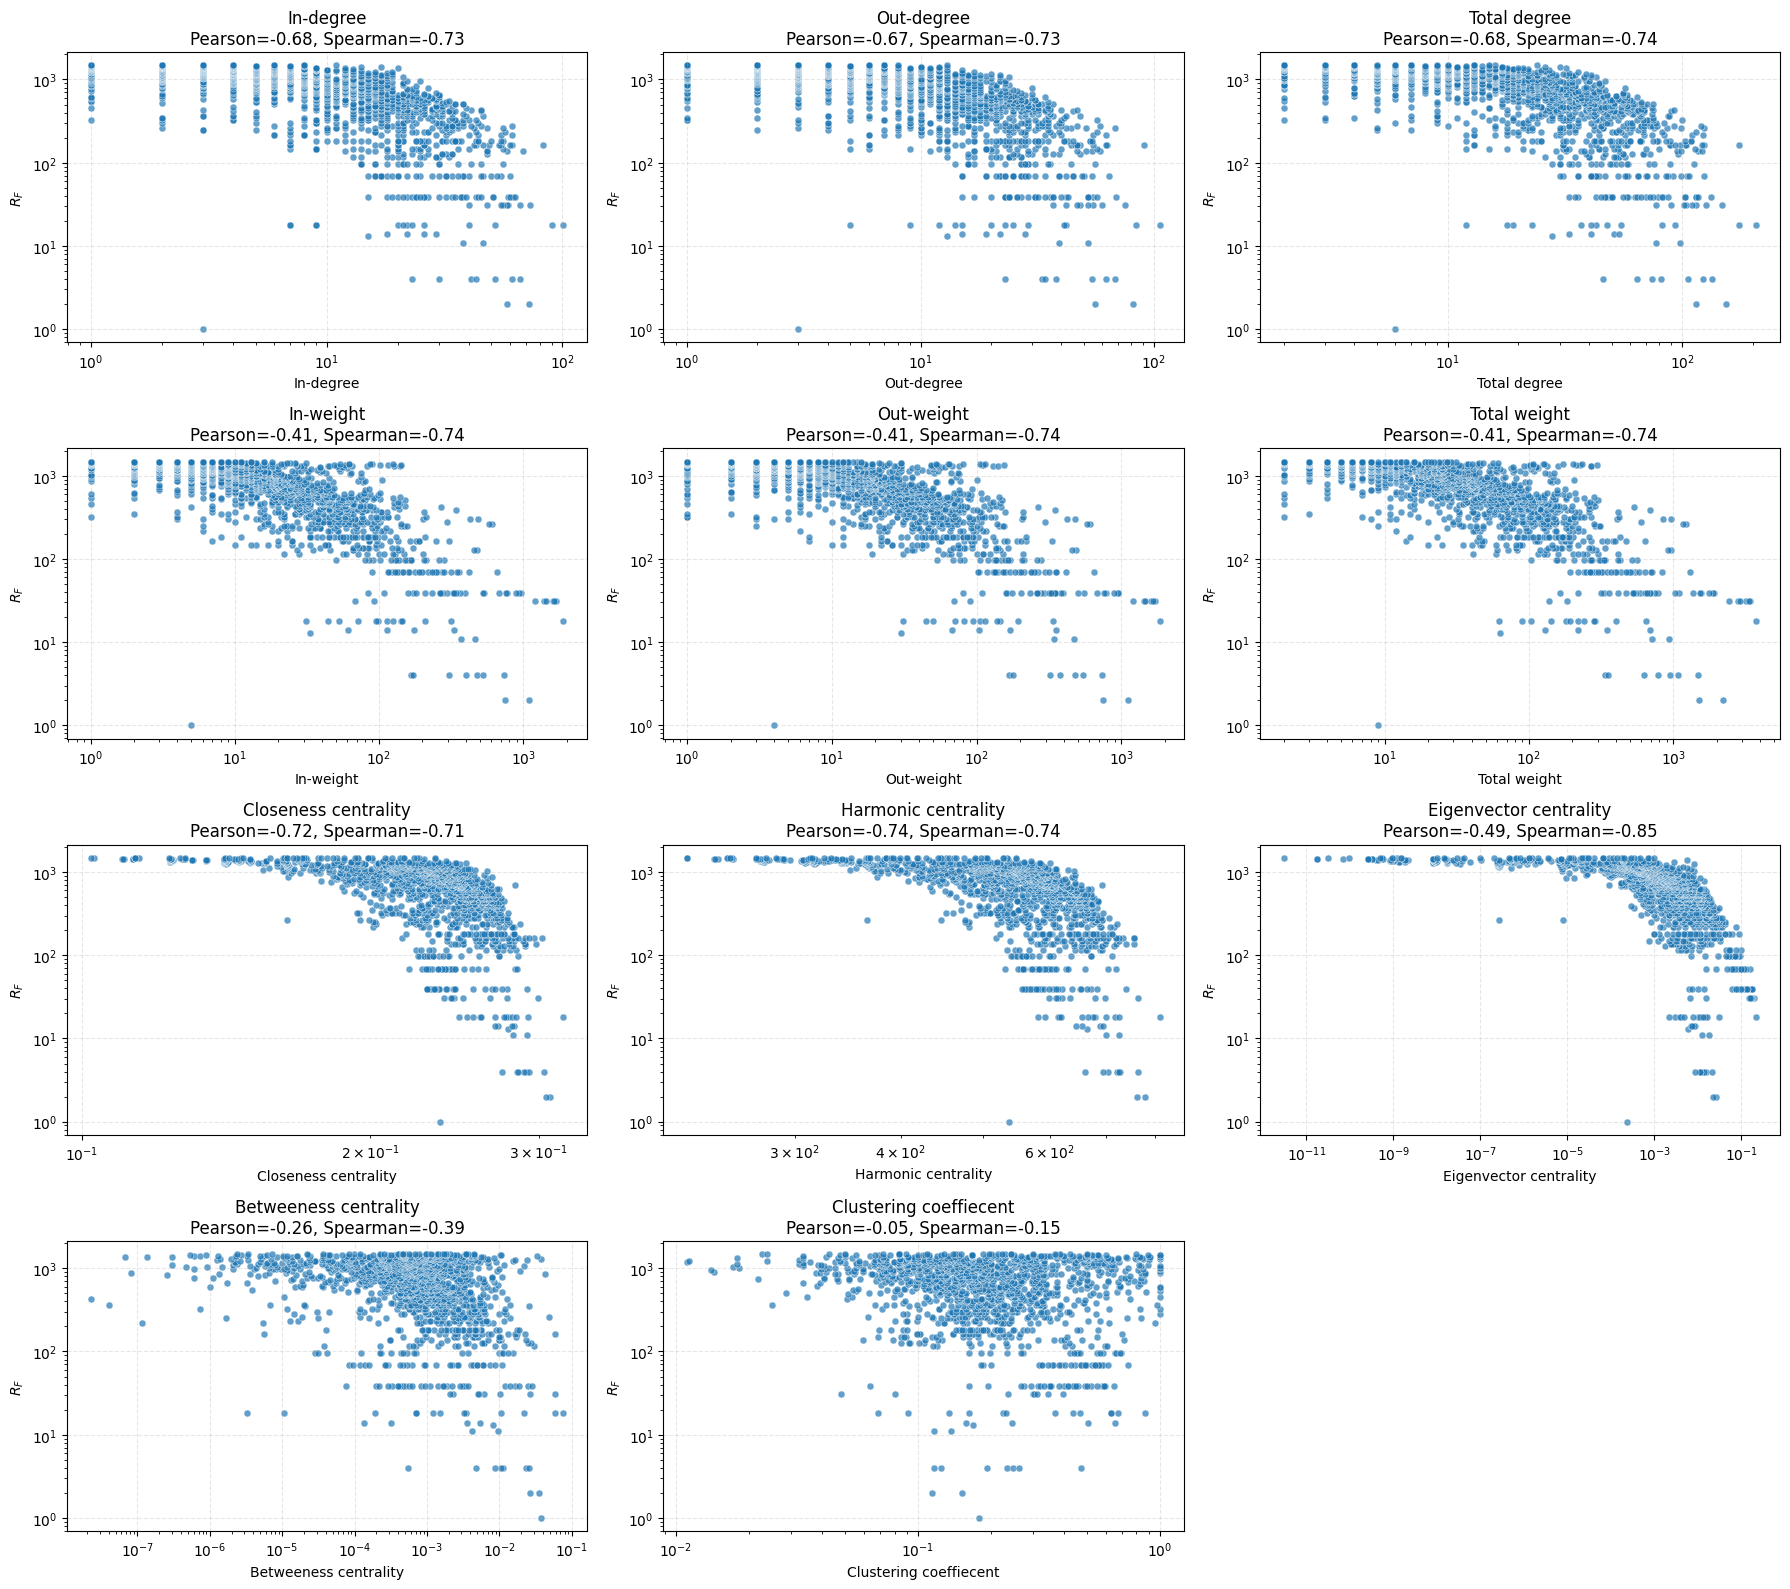

In [9]:
# %% [markdown]
# # Sentinel Ranking Analysis
# This notebook visualizes how R_F varies with degree and centrality metrics.
# It uses log–log scatter plots and displays both Pearson and Spearman correlations.

# %%
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr

# Load the dataset
df = pd.read_csv("sentinel_rank_table.csv")

# Define metric columns and readable labels
metric_map = {
    "i_d": "In-degree",
    "o_d": "Out-degree",
    "d": "Total degree",
    "i_w": "In-weight",
    "o_w": "Out-weight",
    "w": "Total weight",
    "close": "Closeness centrality",
    "harm": "Harmonic centrality",
    "ev": "Eigenvector centrality",
    'bc': "Betweeness centrality",
    'clust':'Clustering coeffiecent'
}

# Ensure R_F is numeric
df["R_F"] = pd.to_numeric(df["R_F"], errors="coerce")

# Set up plotting grid
cols = 3
rows = (len(metric_map) + cols - 1) // cols
plt.figure(figsize=(6 * cols, 4 * rows))

# Generate scatter plots
for i, (col, label) in enumerate(metric_map.items(), 1):
    plt.subplot(rows, cols, i)
    
    # Drop NA and filter positive values for log scaling
    subdf = df[[col, "R_F"]].dropna()
    subdf = subdf[(subdf[col] > 0) & (subdf["R_F"] > 0)]
    
    # Compute correlations
    pearson_corr, _ = pearsonr(subdf[col], subdf["R_F"])
    spearman_corr, _ = spearmanr(subdf[col], subdf["R_F"])
    
    # Plot
    sns.scatterplot(x=subdf[col], y=subdf["R_F"], s=25, alpha=0.7)
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel(label)
    plt.ylabel(f"$R_F$")
    plt.title(f"{label}\nPearson={pearson_corr:.2f}, Spearman={spearman_corr:.2f}")
    plt.grid(True, linestyle="--", alpha=0.3)

plt.tight_layout()
plt.savefig("RF_vs_network_metrics_loglog.png", dpi=300, bbox_inches="tight")
#plt.show()

# %%
# Optional: Display correlation table sorted by strongest Spearman correlation
corrs = []
for col, label in metric_map.items():
    subdf = df[[col, "R_F"]].dropna()
    subdf = subdf[(subdf[col] > 0) & (subdf["R_F"] > 0)]
    pearson_corr, _ = pearsonr(subdf[col], subdf["R_F"])
    spearman_corr, _ = spearmanr(subdf[col], subdf["R_F"])
    corrs.append({"Metric": label, "Pearson": pearson_corr, "Spearman": spearman_corr})

corr_df = pd.DataFrame(corrs).sort_values("Spearman", ascending=False)
display(corr_df)


In [10]:
# ----- parameters -----
p = 10   # top 10%
deg_col = "d"   # change to your actual degree column name
rank_col = "R_T"
# ----- select top sets -----
n = len(agg)
k = int(np.ceil(n * p / 100))

# high degree = good, so take nlargest
top_deg = set(df[deg_col].nlargest(k).index)
# low rank = good, so take nsmallest
top_rf  = set(df[rank_col].nsmallest(k).index)

# ----- compute Jaccard -----
jaccard = len(top_deg & top_rf) / len(top_deg | top_rf)

# ----- compute NMI -----
y_true = np.zeros(n)
y_pred = np.zeros(n)
y_true[list(top_rf)] = 1
y_pred[list(top_deg)] = 1
nmi = normalized_mutual_info_score(y_true, y_pred)

print(f"Top {p}% comparison ({deg_col} vs {rank_col})")
print(f"  Jaccard: {jaccard:.4f}")
print(f"  NMI:     {nmi:.4f}")

Top 10% comparison (d vs R_T)
  Jaccard: 0.2851
  NMI:     0.1463


In [11]:
import numpy as np
import pandas as pd
from sklearn.metrics import normalized_mutual_info_score
from itertools import product

# Helper functions
def top_indices(series, pct, ascending=True):
    """
    Returns a set of node indices corresponding to the top pct% of the series.
    ascending=True means lower = better (e.g. ranks), False means higher = better (e.g. degree).
    """
    k = int(np.ceil(len(series) * pct / 100))
    if ascending:
        top = series.nsmallest(k)
    else:
        top = series.nlargest(k)
    return set(top.index)

def jaccard(a, b):
    return len(a & b) / len(a | b) if (a | b) else 0.0

def nmi_sets(a, b, n):
    y_true = np.zeros(n)
    y_pred = np.zeros(n)
    y_true[list(a)] = 1
    y_pred[list(b)] = 1
    return normalized_mutual_info_score(y_true, y_pred)

# Example metrics to compare (make sure these columns exist)
metrics = ["d", "w", "ev"]   # total degree, total weight, eigenvector centrality
percents = [1, 5, 10]

n = len(agg)
results = []

for m, p in product(metrics, percents):
    if m not in df.columns:
        print(f"Skipping missing column: {m}")
        continue
    top_metric = top_indices(df[m], p, ascending=False)   # high metric = good
    top_rf = top_indices(df["R_I"], p, ascending=True)    # low rank = good
    j = jaccard(top_metric, top_rf)
    nmi = nmi_sets(top_metric, top_rf, n)
    results.append({
        "Metric": m,
        "Top %": p,
        "Jaccard": round(j, 4),
        "NMI": round(nmi, 4)
    })

deg_comp = pd.DataFrame(results)
print(deg_comp)


  Metric  Top %  Jaccard     NMI
0      d      1   0.1034  0.0713
1      d      5   0.2667  0.1753
2      d     10   0.3188  0.1782
3      w      1   0.1429  0.1108
4      w      5   0.4074  0.3190
5      w     10   0.4950  0.3599
6     ev      1   0.0323  0.0111
7     ev      5   0.2562  0.1650
8     ev     10   0.3482  0.2070


,Metric,Pearson,Spearman
10,Clustering coeffiecent,-0.087276,-0.204363
9,Betweeness centrality,-0.246951,-0.394968
6,Closeness centrality,-0.519340,-0.593164
7,Harmonic centrality,-0.555242,-0.622158
0,In-degree,-0.654520,-0.660975
1,Out-degree,-0.655695,-0.666691
2,Total degree,-0.659539,-0.668736
4,Out-weight,-0.400671,-0.687849
3,In-weight,-0.400936,-0.694537
5,Total weight,-0.400887,-0.694617


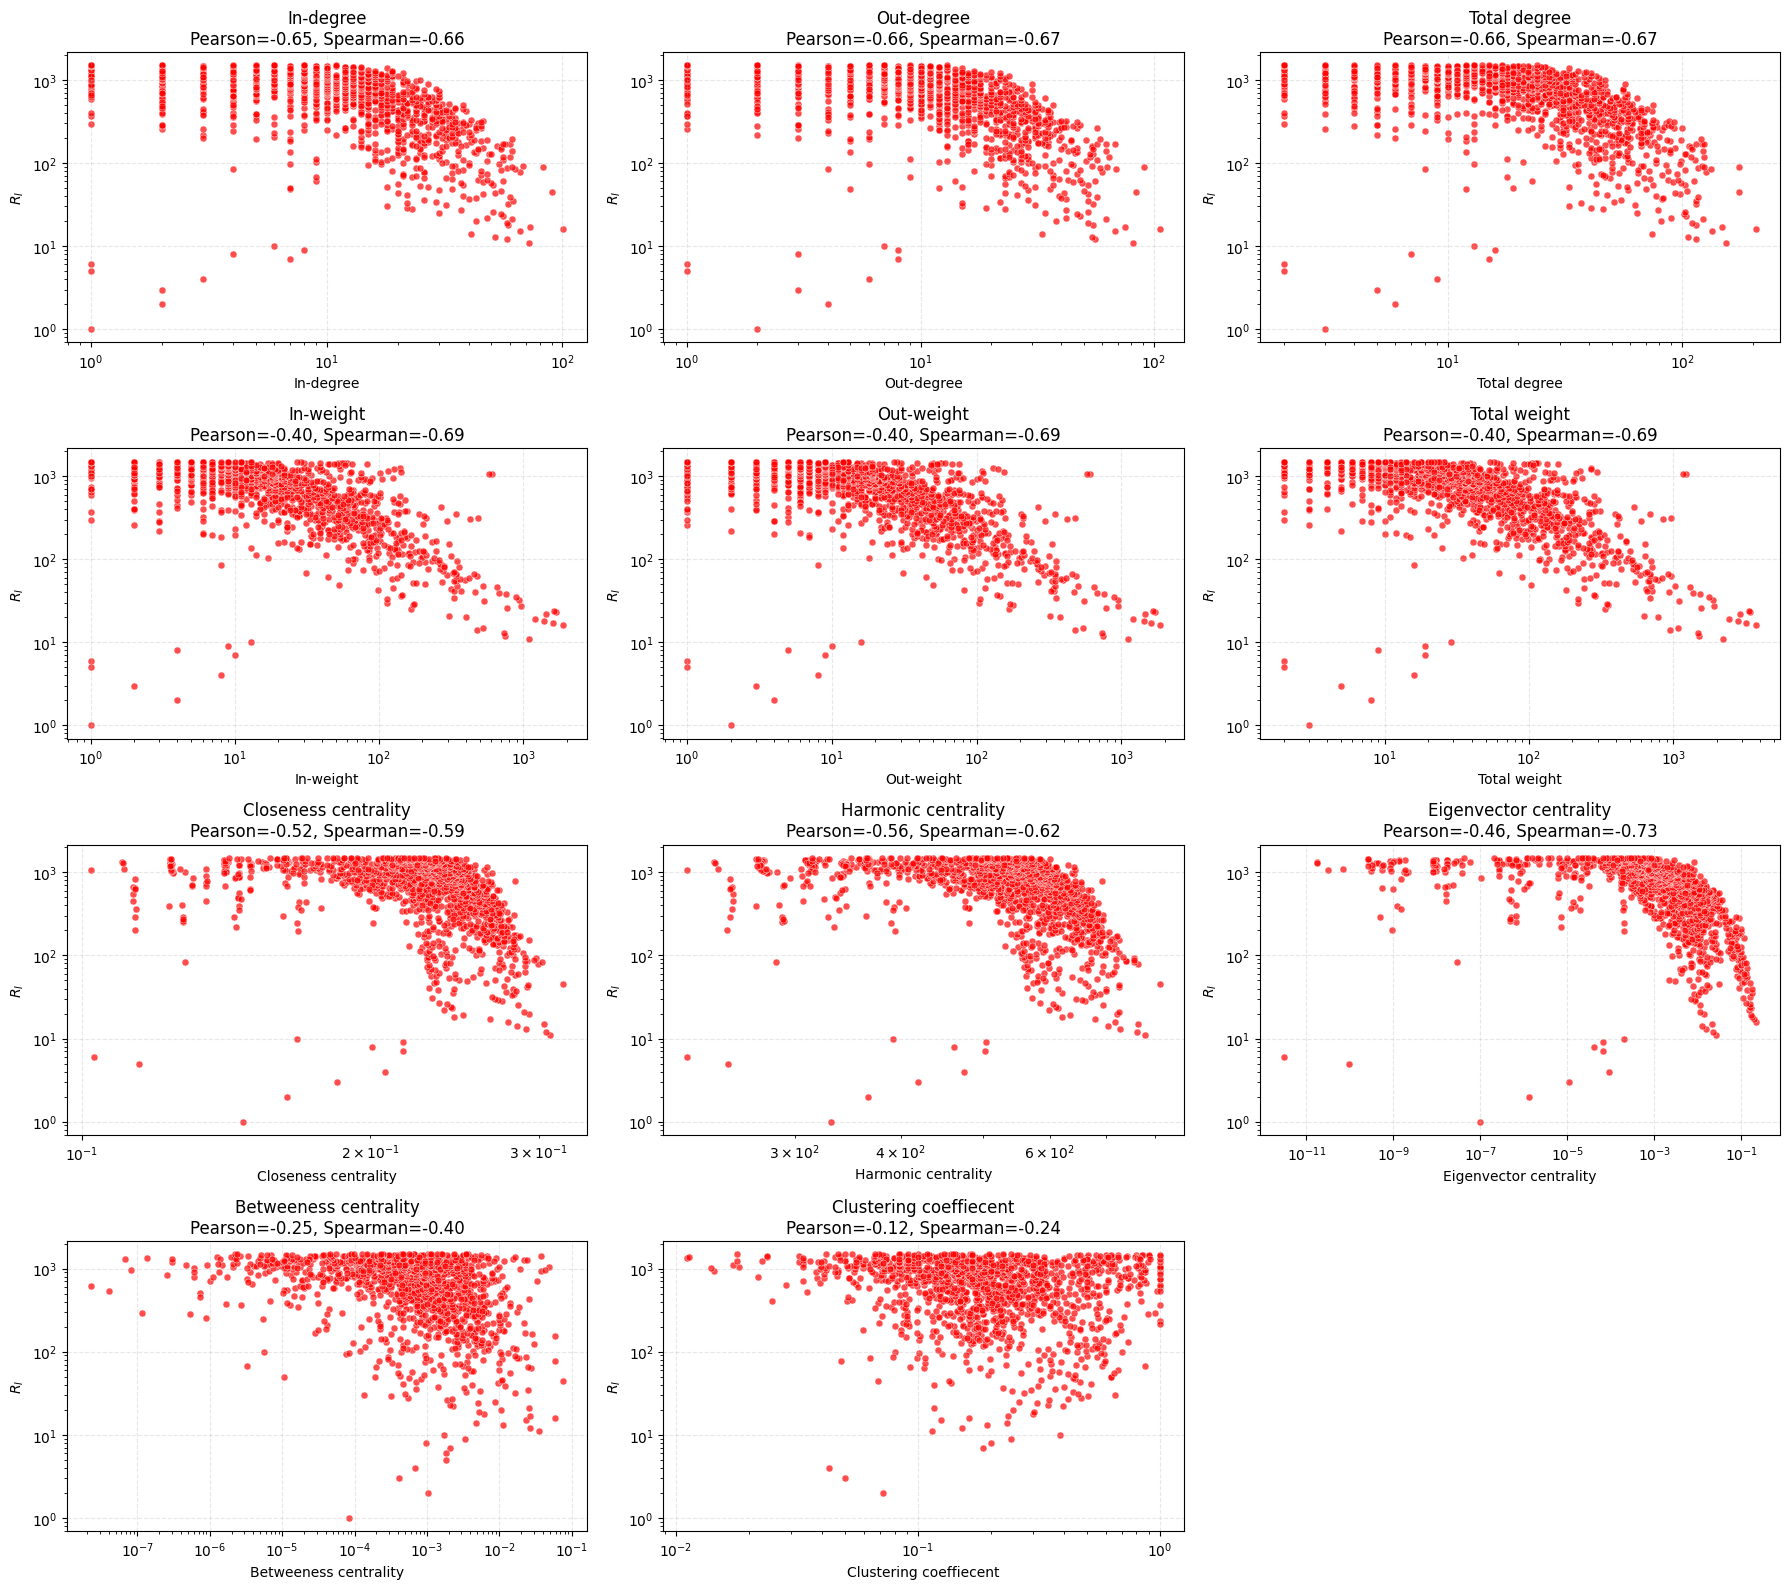

In [12]:
# %% [markdown]
# # Sentinel Ranking Analysis
# This notebook visualizes how R_F varies with degree and centrality metrics.
# It uses log–log scatter plots and displays both Pearson and Spearman correlations.

# %%
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr

# Load the dataset
df = pd.read_csv("sentinel_rank_table.csv")

# Define metric columns and readable labels
metric_map = {
    "i_d": "In-degree",
    "o_d": "Out-degree",
    "d": "Total degree",
    "i_w": "In-weight",
    "o_w": "Out-weight",
    "w": "Total weight",
    "close": "Closeness centrality",
    "harm": "Harmonic centrality",
    "ev": "Eigenvector centrality",
    'bc': "Betweeness centrality",
    'clust':'Clustering coeffiecent'
}

# Ensure R_F is numeric
df["R_I"] = pd.to_numeric(df["R_I"], errors="coerce")

# Set up plotting grid
cols = 3
rows = (len(metric_map) + cols - 1) // cols
plt.figure(figsize=(6 * cols, 4 * rows))

# Generate scatter plots
for i, (col, label) in enumerate(metric_map.items(), 1):
    plt.subplot(rows, cols, i)
    
    # Drop NA and filter positive values for log scaling
    subdf = df[[col, "R_I"]].dropna()
    subdf = subdf[(subdf[col] >= 0) & (subdf["R_I"] >= 0)]
    
    # Compute correlations
    pearson_corr, _ = pearsonr(subdf[col], subdf["R_I"])
    spearman_corr, _ = spearmanr(subdf[col], subdf["R_I"])
    
    # Plot
    sns.scatterplot(x=subdf[col], y=subdf["R_I"], s=25, alpha=0.7,c="red")
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel(label)
    plt.ylabel(f"$R_I$")
    plt.title(f"{label}\nPearson={pearson_corr:.2f}, Spearman={spearman_corr:.2f}")
    plt.grid(True, linestyle="--", alpha=0.3)

plt.tight_layout()
plt.savefig("RI_vs_network_metrics_loglog.png", dpi=300, bbox_inches="tight")
#plt.show()

# %%
# Optional: Display correlation table sorted by strongest Spearman correlation
corrs = []
for col, label in metric_map.items():
    subdf = df[[col, "R_I"]].dropna()
    subdf = subdf[(subdf[col] > 0) & (subdf["R_I"] > 0)]
    pearson_corr, _ = pearsonr(subdf[col], subdf["R_I"])
    spearman_corr, _ = spearmanr(subdf[col], subdf["R_I"])
    corrs.append({"Metric": label, "Pearson": pearson_corr, "Spearman": spearman_corr})

corr_df = pd.DataFrame(corrs).sort_values("Spearman", ascending=False)
display(corr_df)


,Metric,Pearson,Spearman
10,Clustering coeffiecent,-0.067115,-0.181431
9,Betweeness centrality,-0.242276,-0.397946
6,Closeness centrality,-0.531264,-0.578186
7,Harmonic centrality,-0.562587,-0.608026
0,In-degree,-0.633362,-0.643574
1,Out-degree,-0.633227,-0.645624
2,Total degree,-0.637579,-0.649480
4,Out-weight,-0.392865,-0.666457
5,Total weight,-0.393255,-0.675700
3,In-weight,-0.393481,-0.677585


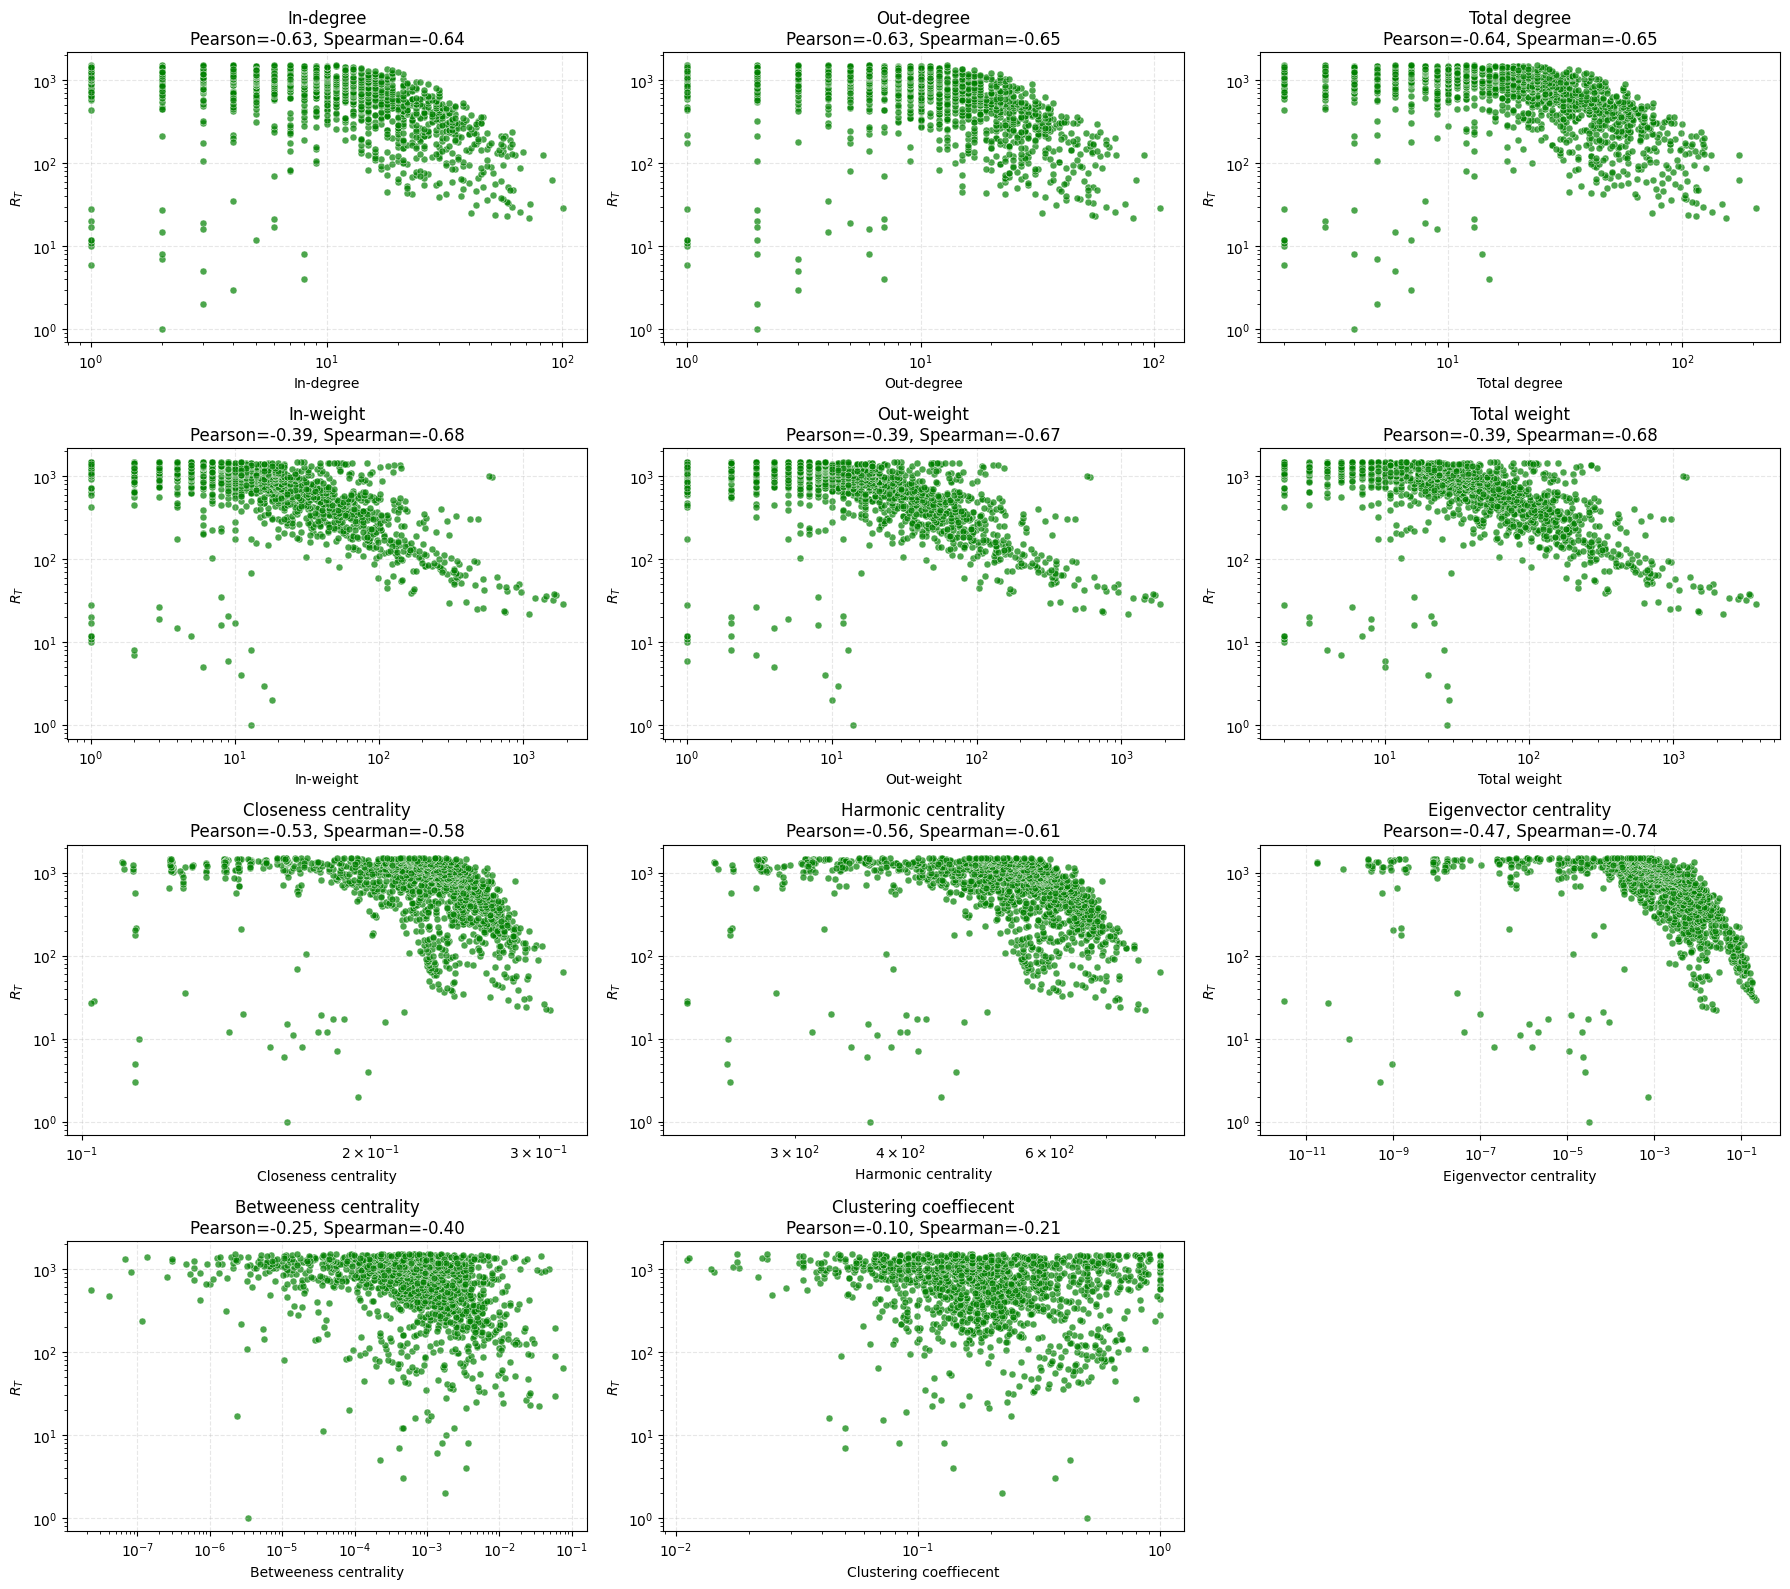

In [13]:
# %% [markdown]
# # Sentinel Ranking Analysis
# This notebook visualizes how R_F varies with degree and centrality metrics.
# It uses log–log scatter plots and displays both Pearson and Spearman correlations.

# %%
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr

# Load the dataset
df = pd.read_csv("sentinel_rank_table.csv")

# Define metric columns and readable labels
metric_map = {
    "i_d": "In-degree",
    "o_d": "Out-degree",
    "d": "Total degree",
    "i_w": "In-weight",
    "o_w": "Out-weight",
    "w": "Total weight",
    "close": "Closeness centrality",
    "harm": "Harmonic centrality",
    "ev": "Eigenvector centrality",
    'bc': "Betweeness centrality",
    'clust':'Clustering coeffiecent'
}

# Ensure R_F is numeric
df["R_I"] = pd.to_numeric(df["R_T"], errors="coerce")

# Set up plotting grid
cols = 3
rows = (len(metric_map) + cols - 1) // cols
plt.figure(figsize=(6 * cols, 4 * rows))

# Generate scatter plots
for i, (col, label) in enumerate(metric_map.items(), 1):
    plt.subplot(rows, cols, i)
    
    # Drop NA and filter positive values for log scaling
    subdf = df[[col, "R_T"]].dropna()
    subdf = subdf[(subdf[col] >= 0) & (subdf["R_T"] >= 0)]
    
    # Compute correlations
    pearson_corr, _ = pearsonr(subdf[col], subdf["R_T"])
    spearman_corr, _ = spearmanr(subdf[col], subdf["R_T"])
    
    # Plot
    sns.scatterplot(x=subdf[col], y=subdf["R_T"], s=25, alpha=0.7,c="green")
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel(label)
    plt.ylabel(f"$R_T$")
    plt.title(f"{label}\nPearson={pearson_corr:.2f}, Spearman={spearman_corr:.2f}")
    plt.grid(True, linestyle="--", alpha=0.3)

plt.tight_layout()
plt.savefig("RT_vs_network_metrics_loglog.png", dpi=300, bbox_inches="tight")
#plt.show()

# %%
# Optional: Display correlation table sorted by strongest Spearman correlation
corrs = []
for col, label in metric_map.items():
    subdf = df[[col, "R_T"]].dropna()
    subdf = subdf[(subdf[col] > 0) & (subdf["R_T"] > 0)]
    pearson_corr, _ = pearsonr(subdf[col], subdf["R_T"])
    spearman_corr, _ = spearmanr(subdf[col], subdf["R_T"])
    corrs.append({"Metric": label, "Pearson": pearson_corr, "Spearman": spearman_corr})

corr_df = pd.DataFrame(corrs).sort_values("Spearman", ascending=False)
display(corr_df)


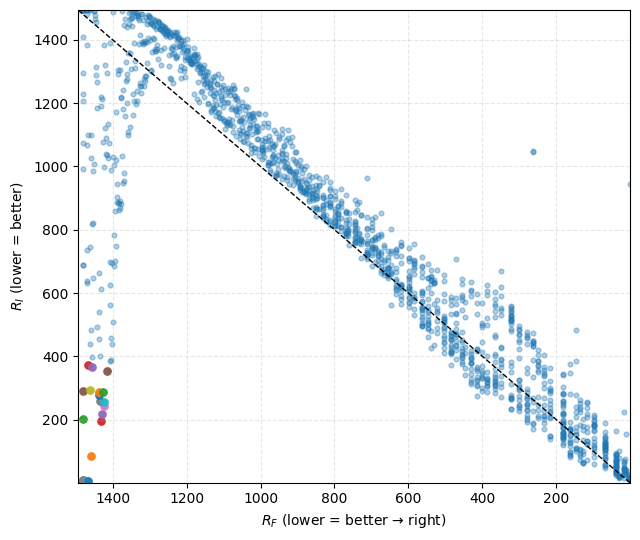

KeyError: "['sent'] not in index"

In [15]:
import numpy as np, matplotlib.pyplot as plt

df = agg.copy()
# relative gap is nicer when ranges differ
for c in ["R_F","R_I","R_T"]:
    df[c+"_norm"] = (df[c]-df[c].min())/(df[c].max()-df[c].min())

df["gap_FI"]  = (df["R_F"]-df["R_I"]).abs()
df["rgap_FI"] = (df["R_F_norm"]-df["R_I_norm"]).abs()

K = 25
out = df.sort_values("rgap_FI", ascending=False).head(K)

# headline scatter with inverted x (worse left → better right)
plt.figure(figsize=(6.5,5.5))
plt.scatter(df["R_F"], df["R_I"], s=12, alpha=.35)
mn = float(np.minimum(df["R_F"].min(), df["R_I"].min()))
mx = float(np.maximum(df["R_F"].max(), df["R_I"].max()))
plt.plot([mn,mx],[mn,mx],'--',lw=1,color='k')
plt.xlim(mn,mx); plt.ylim(mn,mx); plt.gca().invert_xaxis()
plt.xlabel(r"$R_F$ (lower = better → right)")
plt.ylabel(r"$R_I$ (lower = better)")
plt.grid(True, ls="--", alpha=.3)

# label the top discordant nodes
for _,r in out.iterrows():
    plt.scatter(r["R_F"], r["R_I"], s=28, alpha=.9)
    #plt.text(r["R_F"], r["R_I"], str(int(r["sent"])), fontsize=7, ha='left', va='bottom')

plt.tight_layout(); plt.savefig("RF_vs_RI_outliers.png", dpi=300, bbox_inches="tight"); plt.show()

# small table for slide
out_table = out[["sent","R_F","R_I","gap_FI","R_F_norm","R_I_norm","rgap_FI"]].reset_index(drop=True)
out_table


In [ ]:
plt.scatter(list(rank_table["i_w"]),list(rank_table["i_d"]))
plt.xlabel("In-Weight")
plt.ylabel("In-Degree")

In [ ]:
# python3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# ranks: DataFrame with columns R_F, R_I, R_T (index = sentinels)

TOP_N = 100
SELECT_BY = "R_F"
OUTFILE = "rankings_3d_0_100_clipped.png"

# Select top-N by the chosen metric
k = min(TOP_N, len(ranks))
top_ids = ranks[SELECT_BY].nsmallest(k).index
top = ranks.loc[top_ids].copy()

# Count out-of-bounds (any axis > 100) among the top-N
oob_mask_any = (top[["R_T", "R_I", "R_F"]] > 100).any(axis=1)
n_oob_any = int(oob_mask_any.sum())

# (Optional) per-axis counts
n_oob_rt = int((top["R_T"] > 100).sum())
n_oob_ri = int((top["R_I"] > 100).sum())
n_oob_rf = int((top["R_F"] > 100).sum())

# Keep only in-bounds points for plotting (hard clip)
in_bounds = top.loc[~oob_mask_any].copy()

# Color by the selected ranking
colors = in_bounds[SELECT_BY].astype(float)

fig = plt.figure(figsize=(7.8, 6.4))
ax = fig.add_subplot(111, projection="3d")

sc = ax.scatter(
    in_bounds["R_T"].values,
    in_bounds["R_I"].values,
    in_bounds["R_F"].values,
    s=45,
    c=colors.values,
    cmap="viridis",
    depthshade=True,
    edgecolor="k",
    alpha=0.9,
)

ax.set_xlabel(f"$R_T$ (lower is better)")
ax.set_ylabel(f"$R_I$ (lower is better)")
ax.set_zlabel(f"$R_F$ (lower is better)")
ax.set_title(f"Top {k} by {SELECT_BY}: 3D Rank Scatter ($R_T$, $R_I$, $R_F$)")

# Show 0–100 window and invert (best corner near viewer)
ax.set_xlim(0, 100); ax.invert_xaxis()
ax.set_ylim(0, 100); ax.invert_yaxis()
ax.set_zlim(0, 100); ax.invert_zaxis()

# Colorbar + OOB counts
cbar = fig.colorbar(sc, ax=ax, pad=0.1, shrink=0.75)
cbar.set_label(f"{SELECT_BY} (rank value)", rotation=270, labelpad=15)
cbar.ax.text(
    0.5, -0.12,
    f"Top-{k} nodes with any rank > 100: {n_oob_any}\n"
    f"($R_T$>{100}: {n_oob_rt}, $R_I$>{100}: {n_oob_ri}, $R_F$>{100}: {n_oob_rf})",
    transform=cbar.ax.transAxes,
    ha="center", va="top", fontsize=9
)

plt.tight_layout()
plt.savefig(OUTFILE, dpi=300)
plt.close()
print(f"Saved 3D plot → {OUTFILE} (plotted {len(in_bounds)} in-bounds points; "
      f"hidden {n_oob_any} out-of-bounds)")
